In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# CREATING A GMM CLASS
class GaussianMixtureModel:
    
    # INITIALIZATION FUNCTION
    # Uses K-Means to Initialize Our Weights
    # PARAMETERS: self (object), X (dataset), k (number of centroids)
    def Initialize(self, X, k):
        n, f = X.shape
        mu = np.zeros((1, f))
        r = np.zeros((1, k))
        pi = np.array(0)
        sigma = np.zeros((1, f, f))
        
        # This loop randomly picks points from the data to be our initial centroids, and places them into an array
        for num in range(k):
            rand = np.random.randint(n)
            mu = np.append(mu, X[rand:rand + 1], axis = 0)
        
        mu = mu[1:]
        
        # Calculating the Squared-Euclidean Distance from each datapoint to each initial centroid. The squared distances are then placed into a temporary array.
        for i in X:
            token = 0
            temp = 0
            for j in mu:
                token = i-j
                token = np.square(token)
                token = np.sum(token)
                temp = np.append(temp, token)
            
            temp = temp[1:]
            
            minval = temp[0:1]
            index = 0
            # Finding our minimum distance, and grabbing the index to map each datapoint to its nearest centroid.
            # I compared the value at each index to see which one is the minimum.
            for it in range(k):
                if(temp[it:it+1] <= minval):
                    minval = temp[it:it+1]
                    index = it
            
            # For the index selected from our last loop, we insert a value of '1' into the same index of this new list. This list will act as a temporary 'r'.
            temp2 = np.zeros((1, k))
            temp2[0, index:index+1] = 1
            r = np.append(r, temp2, axis = 0)
        
        r = r[1:]
        
        # Calculating our initial prior probabilities (our values stored in pi) using our values stored in r
        # Adds up all the 1's in each column, and divides by the total (1000)
        for q in range(k):
            total = np.sum(r[:, q])
            total = total/n
            pi = np.append(pi, total)
        
        pi = pi[1:]
        
        # Calculating our initial covariance tensor values.
        # Uses 3 loops. First loop is for each k. The next 2 loops are for the number of features (2 in this case).
        cov = 0
        for z in range(k):
            cov = np.zeros((f, f))
            total = np.sum(r[:, z])
            
            # Calculates Covariance[i = 0, j = 0], Covariance[i = 1, j = 0], Covariance[i = 0, j = 1], and Covariance[i = 1, j = 1], giving us a 2x2 matrix.
            for i in range(f):
                for j in range(f):
                    values = X - mu[z]
                    values1 = values[:, i]
                    values1 = np.multiply(r[:, z], values1)
                    values2 = values[:, j]
                    values2 = np.multiply(r[:, z], values2)
                    cov[i, j] = 1/total * np.sum(values1 * values2)
            
            # Each Covariance Matrix is appended to sigma to create our Covariance Tensor.
            sigma = np.append(sigma[:, :], [cov], axis = 0)
        
        sigma = sigma[1:, :]
        return n, f, r, pi, mu, sigma
                
                
    
    # EXPECTATION FUNCTION
    # PARAMETERS: self (object), X (dataset), k (number of clusters), pi (mixture weights), mu (means of each gaussian), sigma (covariance matrices)
    # NOTE: The sum of each value in a row of our returned r matrix adds to 1!
    def Expectation(self, X, k, pi, mu, sigma):
        n, f = X.shape
        r = np.zeros((1, k))
        
        # This block of code calculates a Probability Density from our values of mu and sigma. Once completed, it is multiplied by our prior probability (pi). All calculations are summed together for our next block of code.
        for i in X:
            sumOfP = 0
            temparr = np.array(0)
            for j in range(k):
                pOfX = 1/(np.power(2 * np.pi, f/2) * np.power(np.linalg.det(sigma[j, :]), 0.5)) * np.exp((-1/2) * np.dot(np.dot((i - mu[j]), np.linalg.inv(sigma[j, :])), (i - mu[j]))) * pi[j]
                sumOfP = sumOfP + pOfX
                
            #This block calculates P(x | pi, mu, sigma), using our Posterior Probability from our Probability Density, our Prior Probability (pi), and our sum of those values    
            for m in range(k):
                pOfX = 1/(np.power(2 * np.pi, f/2) * np.power(np.linalg.det(sigma[m, :]), 0.5)) * np.exp((-1/2) * np.dot(np.dot((i - mu[m]), np.linalg.inv(sigma[m, :])), (i - mu[m]))) * pi[m]
                pOfX = (pOfX / np.sum(sumOfP))
                temparr = np.append(temparr, pOfX)
                
            temparr = temparr[1:]
            r = np.append(r, [temparr], axis = 0)
        
        r = r[1:]
        return r
    
    # MAXIMIZE MEAN FUNCTION
    # PARAMETERS: self (object), X (dataset), k (number of clusters), r (membership weights)
    # Utilizes the equation: mu = (1 / N[k]) * sum(w[ik] * x[i]) and updates our means of each cluster
    def MaximizeMean(self, X, k, r):
        n, f = X.shape
        mu = np.zeros((1, f))
        newMu = 0
        for j in range(k):
            total = np.sum(r[:, j])
            newMu = 1/total * np.dot(X.T, r[:, j])
            mu = np.append(mu, [newMu], axis = 0)
        
        mu = mu[1:]
        return mu
                
    # MAXIMIZE COVARIANCE FUNCTION
    # PARAMETERS: self (object), X (dataset), k (number of clusters), r (membership weights), mu (means of each gaussian)
    # Performs a similar formula from our k-means initialization. 3 loops (one for each cluster (k), and two for the number of dimensions)
    # Utilizes the equation: sigma = (1 / N[k]) * sum(w[ik] * (x - mu)(x - mu))
    def MaximizeCovariance(self, X, k, r, mu):
        sigma = np.zeros((1, f, f))
        cov = 0
        for z in range(k):
            cov = np.zeros((f, f))
            total = np.sum(r[:, z])
            for i in range(f):
                for j in range(f):
                    values = X - mu[z]
                    values1 = values[:, i]
                    values2 = values[:, j]
                    cov[i, j] = 1/total * np.dot((values1 * values2), r[:, z])
                
            sigma = np.append(sigma[:, :], [cov], axis = 0)
        
        sigma = sigma[1:, :]
        return sigma
        
        
    # MAXIMIZE MIXTURES FUNCTION
    # PARAMETERS: self (object), k (number of clusters), r (membership weights)
    # Uses pretty much the same formula from our K-means initialization. Sums up each column and divides by the total (1000).
    # NOTE: The sum of each index of our pi array adds up to 1!
    def MaximizeMixtures(self, k, r):
        n = len(r)
        pi = np.array(0)
        temp = np.array(0)
        
        for i in range(k):
            total = np.sum(r[:, i])
            total = total/n
            pi = np.append(pi, total)
        
        pi = pi[1:]
        return pi
    
    # OUR EM FUNCTION
    # PARAMETERS: self (object), X (data), k (number of clusters), pi (mixture weights), mu (means of each gaussian), sigma (covariance tensor), niters (number of desired iterations)
    # NOTE: I know the assigment only told us to return pi, mu, and sigma from this method. However, in order to produce my plot with different colored clusters, I needed the values stored in r as well.
    def EM(self, X, k, pi, mu, sigma, niters):
        for i in range(niters):
            r = self.Expectation(data, k, pi, mu, sigma)
            mu = self.MaximizeMean(data, k, r)
            sigma = self.MaximizeCovariance(data, k, r, mu)
            pi = self.MaximizeMixtures(k, r)
            
            # Testing our Log-Likelihood. If correct, our values should increase each iteration. Smaller increases mean we are closer to converging.
            sumLogP = 0
            for j in X:
                allP = 0
                for m in range(k):
                    pOfX = 1/(np.power(2 * np.pi, f/2) * np.power(np.linalg.det(sigma[m, :]), 0.5)) * np.exp((-1/2) * np.dot(np.dot((j - mu[m]), np.linalg.inv(sigma[m, :])), (j - mu[m]))) * pi[m]
                    allP = allP + pOfX
                allP = np.log(allP)
                sumLogP = sumLogP + allP
                
            
            print("The Log Likelihood of iteration", i+1, "is:", sumLogP)
        print('\n')
        return pi, mu, sigma, r
    
    # OUR PLOT FUNCTION FOR VISUALIZING OUR CLUSTERS
    # PARAMETERS: self (object), X (dataset), k (number of clusters), r (membership weights)
    def plot(self, X, k, r):
        # Separating our data into X and Y Labels
        x_label = X[:, 0]
        y_label = X[:, 1]
        
        # Initializing our colors
        colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'tab:purple', 'tab:pink', 'tab:cyan', 'tab:olive', 'tab:brown', 'tab:grey']
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        # Assigning a color to each datapoint, depending on the maximum value associated with r.
        for i in range(len(r)):
            col = np.argmax(r[i])
            ax.scatter(x_label[i], y_label[i], color = colors[col])
        
        plt.show()
            
        

The Log Likelihood of iteration 1 is: -4616.5689083486195
The Log Likelihood of iteration 2 is: -4598.489063232593
The Log Likelihood of iteration 3 is: -4589.471860605169
The Log Likelihood of iteration 4 is: -4581.650027113567
The Log Likelihood of iteration 5 is: -4573.10369140848


The Mean of Cluster 1 is: [-0.63656821 -4.19518873]
The Mean of Cluster 2 is: [-4.65927528 -0.26109984]
The Mean of Cluster 3 is: [0.10403337 0.17971071]


Mixture Weights: [0.15705885 0.16966022 0.67328093]


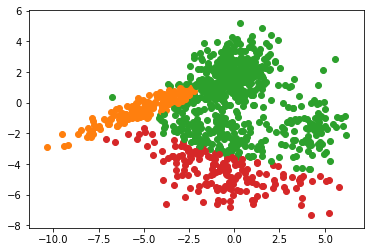

In [8]:
# READING OUR DATA
data = pd.read_csv("points.dat.txt", sep = " ", header = None)
data = data.to_numpy()

# INITIALIZING OUR GMM OBJECT
GMM = GaussianMixtureModel()
k = 3
n, f, r, pi, mu, sigma = GMM.Initialize(data, k)
pi, mu, sigma, r = GMM.EM(data, k, pi, mu, sigma, 5)
        
for l in range(len(mu)):
    print("The Mean of Cluster", l+1, "is:", mu[l])
        
print('\n')        
print("Mixture Weights:", pi)

# NOTE: Wait 4-7 seconds for plot to show up on screen.
GMM.plot(data, k, r)

In [ ]:
# TEST RUN #1:
# GMM = GaussianMixtureModel()
# k = 5
# n, f, r, pi, mu, sigma = GMM.Initialize(data, k)
# GMM.EM(data, k, pi, mu, sigma, 50)
'''The Log Likelihood of iteration 1 is: -4486.121152043609
The Log Likelihood of iteration 2 is: -4459.868515025016
The Log Likelihood of iteration 3 is: -4446.521647594644
The Log Likelihood of iteration 4 is: -4436.86010867447
The Log Likelihood of iteration 5 is: -4427.634647907687
The Log Likelihood of iteration 6 is: -4418.071480759279
The Log Likelihood of iteration 7 is: -4408.647586347114
The Log Likelihood of iteration 8 is: -4400.347256429065
The Log Likelihood of iteration 9 is: -4393.782333658089
The Log Likelihood of iteration 10 is: -4388.88470674311
The Log Likelihood of iteration 11 is: -4385.248497356131
The Log Likelihood of iteration 12 is: -4382.478589723794
The Log Likelihood of iteration 13 is: -4380.298118253844
The Log Likelihood of iteration 14 is: -4378.5311037103365
The Log Likelihood of iteration 15 is: -4377.064917302764
The Log Likelihood of iteration 16 is: -4375.823121401034
The Log Likelihood of iteration 17 is: -4374.7497948064765
The Log Likelihood of iteration 18 is: -4373.801126681333
The Log Likelihood of iteration 19 is: -4372.94087114059
The Log Likelihood of iteration 20 is: -4372.137715471592
The Log Likelihood of iteration 21 is: -4371.363598033124
The Log Likelihood of iteration 22 is: -4370.59250486694
The Log Likelihood of iteration 23 is: -4369.799456524233
The Log Likelihood of iteration 24 is: -4368.959426465539
The Log Likelihood of iteration 25 is: -4368.0459407797525
The Log Likelihood of iteration 26 is: -4367.029188947389
The Log Likelihood of iteration 27 is: -4365.873646948892
The Log Likelihood of iteration 28 is: -4364.53549750869
The Log Likelihood of iteration 29 is: -4362.960795659885
The Log Likelihood of iteration 30 is: -4361.0872337502515
The Log Likelihood of iteration 31 is: -4358.857210099
The Log Likelihood of iteration 32 is: -4356.258415832716
The Log Likelihood of iteration 33 is: -4353.407554400842
The Log Likelihood of iteration 34 is: -4350.631767917093
The Log Likelihood of iteration 35 is: -4348.373340608116
The Log Likelihood of iteration 36 is: -4346.871592270096
The Log Likelihood of iteration 37 is: -4346.0243967291935
The Log Likelihood of iteration 38 is: -4345.589796167513
The Log Likelihood of iteration 39 is: -4345.372759002027
The Log Likelihood of iteration 40 is: -4345.260858348246
The Log Likelihood of iteration 41 is: -4345.1983446348595
The Log Likelihood of iteration 42 is: -4345.159251388529
The Log Likelihood of iteration 43 is: -4345.131651686967
The Log Likelihood of iteration 44 is: -4345.110002078557
The Log Likelihood of iteration 45 is: -4345.091660827462
The Log Likelihood of iteration 46 is: -4345.07532692582
The Log Likelihood of iteration 47 is: -4345.06033389693
The Log Likelihood of iteration 48 is: -4345.046324317552
The Log Likelihood of iteration 49 is: -4345.033096359658
The Log Likelihood of iteration 50 is: -4345.020529553593


The Mean of Cluster 0 is: [-1.36751551 -2.41335371]
The Mean of Cluster 1 is: [-4.21209388 -0.0783246 ]
The Mean of Cluster 2 is: [ 0.47084385 -5.21036329]
The Mean of Cluster 3 is: [-0.02804678  1.82390578]
The Mean of Cluster 4 is: [ 4.13731457 -1.73640034]


Mixture Weights: [0.25980646 0.21101624 0.08005747 0.35343    0.09568983]'''


# TEST RUN #2:
# GMM = GaussianMixtureModel()
# k = 2
# n, f, r, pi, mu, sigma = GMM.Initialize(data, k)
# GMM.EM(data, k, pi, mu, sigma, 20)
'''The Log Likelihood of iteration 1 is: -4743.75074358574
The Log Likelihood of iteration 2 is: -4739.067590198294
The Log Likelihood of iteration 3 is: -4735.34351652265
The Log Likelihood of iteration 4 is: -4731.194194199034
The Log Likelihood of iteration 5 is: -4726.242131594028
The Log Likelihood of iteration 6 is: -4720.510258519804
The Log Likelihood of iteration 7 is: -4714.351667975441
The Log Likelihood of iteration 8 is: -4708.363863052059
The Log Likelihood of iteration 9 is: -4703.175142271949
The Log Likelihood of iteration 10 is: -4699.033204868179
The Log Likelihood of iteration 11 is: -4695.7280681793445
The Log Likelihood of iteration 12 is: -4692.913877305622
The Log Likelihood of iteration 13 is: -4690.319006676235
The Log Likelihood of iteration 14 is: -4687.7514099747605
The Log Likelihood of iteration 15 is: -4685.036099379371
The Log Likelihood of iteration 16 is: -4681.934630256618
The Log Likelihood of iteration 17 is: -4678.005389431271
The Log Likelihood of iteration 18 is: -4672.256488639009
The Log Likelihood of iteration 19 is: -4662.201959728922
The Log Likelihood of iteration 20 is: -4642.360885018217


The Mean of Cluster 0 is: [0.02827346 1.46798991]
The Mean of Cluster 1 is: [-1.53175376 -2.3005204 ]


Mixture Weights: [0.45596968 0.54403032]'''

# TEST RUN #3:
# GMM = GaussianMixtureModel()
# k = 3
# n, f, r, pi, mu, sigma = GMM.Initialize(data, k)
# GMM.EM(data, k, pi, mu, sigma, 40)
'''The Log Likelihood of iteration 1 is: -4713.670934827524
The Log Likelihood of iteration 2 is: -4698.796504844756
The Log Likelihood of iteration 3 is: -4685.591822644537
The Log Likelihood of iteration 4 is: -4670.281859853234
The Log Likelihood of iteration 5 is: -4651.178502988989
The Log Likelihood of iteration 6 is: -4626.567653876623
The Log Likelihood of iteration 7 is: -4597.92722293925
The Log Likelihood of iteration 8 is: -4571.575556123388
The Log Likelihood of iteration 9 is: -4550.643563045239
The Log Likelihood of iteration 10 is: -4533.506233197705
The Log Likelihood of iteration 11 is: -4519.4915994296225
The Log Likelihood of iteration 12 is: -4509.145579045397
The Log Likelihood of iteration 13 is: -4501.979844345578
The Log Likelihood of iteration 14 is: -4496.785174585813
The Log Likelihood of iteration 15 is: -4492.768427800674
The Log Likelihood of iteration 16 is: -4489.680838365929
The Log Likelihood of iteration 17 is: -4487.45892652269
The Log Likelihood of iteration 18 is: -4485.9838727238475
The Log Likelihood of iteration 19 is: -4485.063372351805
The Log Likelihood of iteration 20 is: -4484.504654305783
The Log Likelihood of iteration 21 is: -4484.162773886272
The Log Likelihood of iteration 22 is: -4483.945659877083
The Log Likelihood of iteration 23 is: -4483.800079564224
The Log Likelihood of iteration 24 is: -4483.6966338134125
The Log Likelihood of iteration 25 is: -4483.619286524242
The Log Likelihood of iteration 26 is: -4483.559165129351
The Log Likelihood of iteration 27 is: -4483.5111694454545
The Log Likelihood of iteration 28 is: -4483.472191698813
The Log Likelihood of iteration 29 is: -4483.440201324246
The Log Likelihood of iteration 30 is: -4483.413776931574
The Log Likelihood of iteration 31 is: -4483.391864471127
The Log Likelihood of iteration 32 is: -4483.373648585634
The Log Likelihood of iteration 33 is: -4483.358480637554
The Log Likelihood of iteration 34 is: -4483.3458355509765
The Log Likelihood of iteration 35 is: -4483.33528380975
The Log Likelihood of iteration 36 is: -4483.326471882039
The Log Likelihood of iteration 37 is: -4483.319107690292
The Log Likelihood of iteration 38 is: -4483.312949360928
The Log Likelihood of iteration 39 is: -4483.307796275377
The Log Likelihood of iteration 40 is: -4483.303481834759


The Mean of Cluster 0 is: [1.2690058  0.99322388]
The Mean of Cluster 1 is: [-2.61039656  0.59619818]
The Mean of Cluster 2 is: [-0.76377438 -3.08322685]


Mixture Weights: [0.29386089 0.35416496 0.35197414]'''